# Exploração, Features e Modelo (KPIs de Benefícios)

Este notebook carrega os **KPIs** exportados pelo ETL, faz uma **exploração rápida**, constrói **features temporais** e treina um **modelo de ML** para prever o gasto do **próximo mês por departamento**.

**Entradas (CSV):**
- `data/processed/kpi_monthly_department_expense.csv`
- `data/processed/kpi_3month_moving_avg_department.csv`
- `data/processed/kpi_top10_employee_by_benefit.csv`

**Saídas (CSV):**
- `data/processed/model_metrics.csv`
- `data/processed/predictions_next_month.csv`


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)


In [ ]:
NOTEBOOKS_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOKS_DIR.parent
DATA_DIR = PROJECT_ROOT / "data" / "processed"

f_monthly = DATA_DIR / "kpi_monthly_department_expense.csv"
f_mavg = DATA_DIR / "kpi_3month_moving_avg_department.csv"
f_top10 = DATA_DIR / "kpi_top10_employee_by_benefit.csv"

for f in [f_monthly, f_mavg, f_top10]:
  if not f.exists():
      raise FileNotFoundError(f"Arquivo não encontrado: {f}")

df_monthly = pd.read_csv(f_monthly)
df_mavg = pd.read_csv(f_mavg)
df_top10 = pd.read_csv(f_top10)

for d in [df_monthly, df_mavg]:
    if "mes" in d.columns:
        d["mes"] = pd.to_datetime(d["mes"], errors="coerce")
        d.sort_values(["mes"], inplace=True)

print("monthly shape:", df_monthly.shape)
print("moving_avg shape:", df_mavg.shape)
print("top10 shape:", df_top10.shape)
display(df_monthly.head(3))
display(df_mavg.head(3))
display(df_top10.head(3))


monthly shape: (42, 3)
moving_avg shape: (42, 4)
top10 shape: (60, 5)


,mes,nome_departamento,gasto_total
0,2025-03-01,Financeiro,17946.86
1,2025-03-01,Marketing,19960.94
2,2025-03-01,Operações,23876.16


,mes,nome_departamento,gasto_total,media_movel_3m
0,2025-03-01,Financeiro,17946.86,17946.86
28,2025-03-01,TI,20172.46,20172.46
21,2025-03-01,RH,25747.06,25747.06


,nome_beneficio,id_colaborador,nome_colaborador,valor,pos
0,Alimentação,53,Dr. Lucas Guerra,2693.26,1
1,Alimentação,95,João Felipe Teixeira,1979.95,2
2,Alimentação,182,Antônio Cavalcante,1958.27,3


## EDA — Séries e tendências

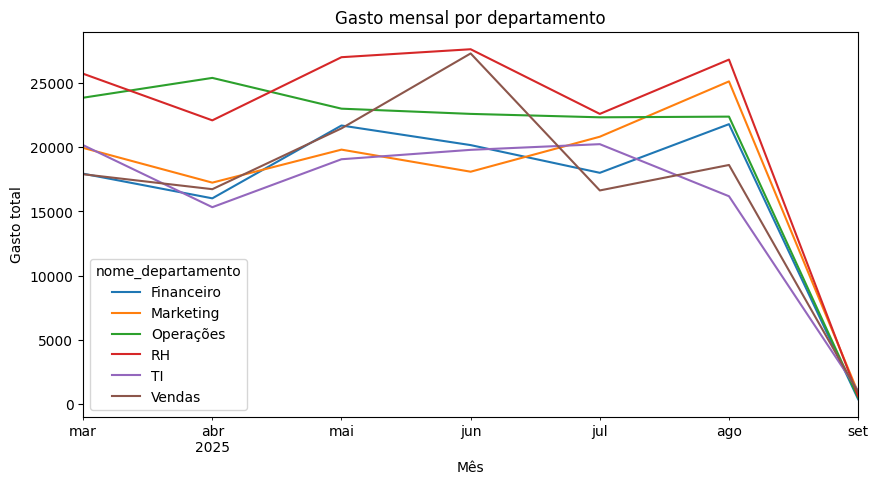

In [ ]:
piv = (
    df_monthly
    .pivot_table(index="mes", columns="nome_departamento", values="gasto_total", aggfunc="sum")
    .sort_index()
)

ax = piv.plot(figsize=(10, 5))
ax.set_title("Gasto mensal por departamento")
ax.set_xlabel("Mês")
ax.set_ylabel("Gasto total")
plt.show()


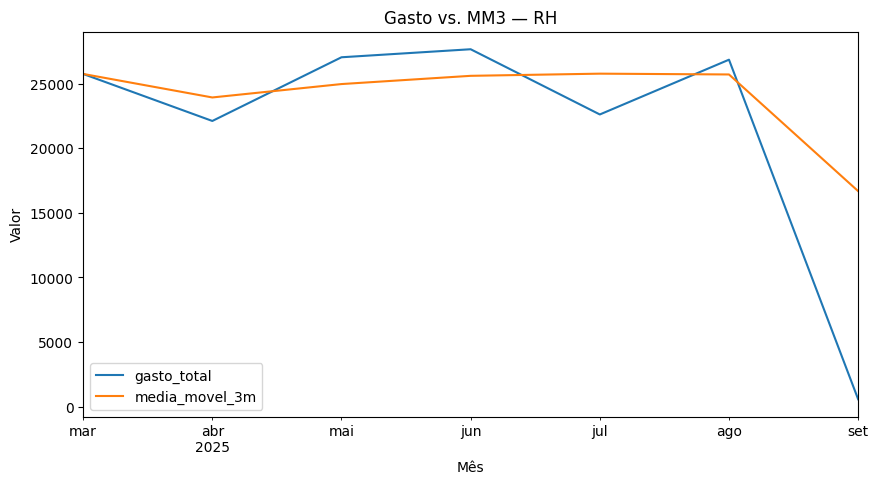

In [ ]:
totals = df_monthly.groupby("nome_departamento")["gasto_total"].sum().sort_values(ascending=False)
top_dept = totals.index[0]

base = (
    df_monthly.loc[df_monthly["nome_departamento"] == top_dept, ["mes", "gasto_total"]]
    .merge(
        df_mavg.loc[df_mavg["nome_departamento"] == top_dept, ["mes", "media_movel_3m"]],
        on="mes",
        how="left"
    )
    .sort_values("mes")
)

ax = base.set_index("mes")[["gasto_total", "media_movel_3m"]].plot(figsize=(10, 5))
ax.set_title(f"Gasto vs. MM3 — {top_dept}")
ax.set_xlabel("Mês")
ax.set_ylabel("Valor")
plt.show()


In [ ]:
df_top10.sort_values(["nome_beneficio", "pos"], inplace=True)
display(df_top10.groupby("nome_beneficio").head(5))


,nome_beneficio,id_colaborador,nome_colaborador,valor,pos
0,Alimentação,53,Dr. Lucas Guerra,2693.26,1
1,Alimentação,95,João Felipe Teixeira,1979.95,2
2,Alimentação,182,Antônio Cavalcante,1958.27,3
3,Alimentação,78,Sra. Mirella Fernandes,1741.60,4
4,Alimentação,174,Felipe Barros,1729.84,5
10,Bem-estar,170,Agatha Albuquerque,2247.98,1
11,Bem-estar,8,Dra. Nicole Cunha,2064.82,2
12,Bem-estar,119,Luna Santos,2017.00,3
13,Bem-estar,10,Henry Gabriel Sá,1767.08,4
14,Bem-estar,160,Thales da Mota,1726.96,5


## Features para ML (prever gasto do próximo mês por departamento)

In [ ]:
feats = (
    df_monthly.merge(
        df_mavg[["nome_departamento", "mes", "media_movel_3m"]],
        on=["nome_departamento", "mes"],
        how="left"
    )
    .sort_values(["nome_departamento", "mes"])
    .reset_index(drop=True)
)

def add_lags(g):
    for k in (1, 2, 3):
        g[f"lag_{k}"] = g["gasto_total"].shift(k)
    g["target_next_month"] = g["gasto_total"].shift(-1)
    return g

feats = feats.groupby("nome_departamento", group_keys=False).apply(add_lags)

feats["mes_num"] = feats["mes"].dt.month
dummies = pd.get_dummies(feats["mes_num"], prefix="m", drop_first=True)
feats = pd.concat([feats, dummies], axis=1)

req_cols = ["lag_1", "lag_2", "lag_3", "media_movel_3m", "target_next_month"]
feats = feats.dropna(subset=req_cols).reset_index(drop=True)

feature_cols = ["lag_1", "lag_2", "lag_3", "media_movel_3m"] + dummies.columns.tolist()
X = feats[feature_cols].copy()
y = feats["target_next_month"].copy()

last_trainable_month = feats.loc[feats["target_next_month"].notna(), "mes"].max()
is_test = feats["mes"] == last_trainable_month
X_train, y_train = X.loc[~is_test], y.loc[~is_test]
X_test, y_test = X.loc[is_test], y.loc[is_test]

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


Train shape: (12, 10) | Test shape: (6, 10)


C:\Users\cesar.carvalho\AppData\Local\Temp\ipykernel_59104\529603311.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feats = feats.groupby("nome_departamento", group_keys=False).apply(add_lags)


## Modelagem (Baseline, Linear Regression, Random Forest)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

baseline_pred = X_test[["lag_1", "lag_2", "lag_3"]].mean(axis=1).values

lin = LinearRegression()
lin.fit(X_train, y_train)
lin_pred = lin.predict(X_test)

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

models = {
    "baseline_mean_lags3": baseline_pred,
    "linear_regression": lin_pred,
    "random_forest": rf_pred
}

rows = []
for name, pred in models.items():
    rmse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    mp = mape(y_test, pred)
    rows.append({"model": name, "rmse": rmse, "mape_pct": mp, "r2": r2})

metrics_df = pd.DataFrame(rows).sort_values("rmse")
display(metrics_df)


,model,rmse,mape_pct,r2
0,baseline_mean_lags3,4.418885e+08,3536.940356,-7774.148372
2,random_forest,4.777246e+08,3698.176270,-8404.694866
1,linear_regression,5.335721e+08,3871.236600,-9387.347119


## Previsão para o próximo mês (por departamento)

In [ ]:
max_mes = feats["mes"].max()
latest = feats.loc[feats["mes"] == max_mes].copy()

latest["pred_baseline_mean_lags3"] = latest[["lag_1", "lag_2", "lag_3"]].mean(axis=1)

latest["pred_linear"] = lin.predict(latest[feature_cols])
latest["pred_rf"] = rf.predict(latest[feature_cols])

out_pred = latest[
    ["nome_departamento", "mes", "gasto_total", "media_movel_3m", "lag_1", "lag_2", "lag_3",
     "pred_baseline_mean_lags3", "pred_linear", "pred_rf"]
].rename(columns={"mes": "mes_base"})

out_metrics = metrics_df.copy()

out_dir = DATA_DIR
out_pred_path = out_dir / "predictions_next_month.csv"
out_metrics_path = out_dir / "model_metrics.csv"

out_pred.to_csv(out_pred_path, index=False, encoding="utf-8")
out_metrics.to_csv(out_metrics_path, index=False, encoding="utf-8")

print("Predições salvas em:", out_pred_path)
print("Métricas salvas em:", out_metrics_path)
display(out_pred.head())


Predições salvas em: c:\Users\cesar.carvalho\OneDrive - Grupo Primo\Área de Trabalho\Teste\data\processed\predictions_next_month.csv
Métricas salvas em: c:\Users\cesar.carvalho\OneDrive - Grupo Primo\Área de Trabalho\Teste\data\processed\model_metrics.csv


,nome_departamento,mes_base,gasto_total,media_movel_3m,lag_1,lag_2,lag_3,pred_baseline_mean_lags3,pred_linear,pred_rf
2,Financeiro,2025-08-01,21812.05,20001.953333,18015.49,20178.32,21706.77,19966.860000,22869.676214,22794.20995
5,Marketing,2025-08-01,25148.95,21361.006667,20832.50,18101.57,19824.92,19586.330000,19833.104764,19596.83290
8,Operações,2025-08-01,22399.99,22453.363333,22346.79,22613.31,23020.60,22660.233333,23274.293107,22533.36725
11,RH,2025-08-01,26850.07,25706.736667,22612.07,27658.07,27037.10,25769.080000,27003.718729,24075.69685
14,TI,2025-08-01,16186.58,18748.430000,20250.79,19807.92,19074.33,19711.013333,21483.954001,21992.68025


## Visualização das previsões com intervalo aproximado de confiança

Gráficos para inspeção do modelo:
1) **Dispersão** (verdade vs. predito) no mês de teste.
2) **Barras por departamento** com **intervalo aproximado** (±1.96·σ dos resíduos do teste).


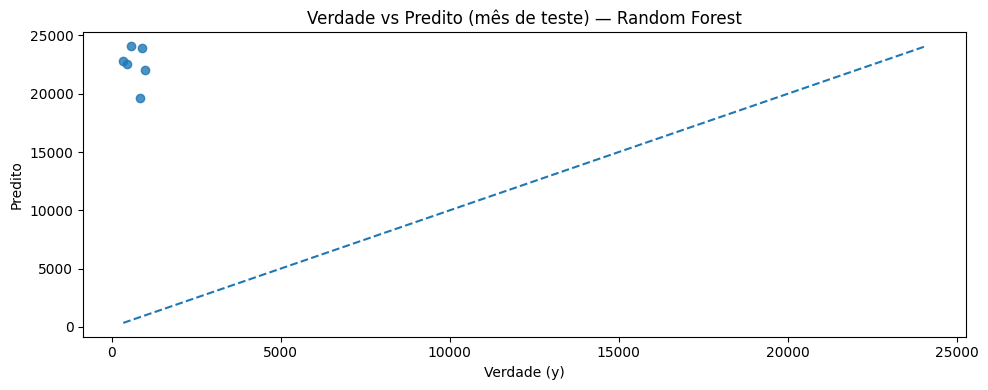

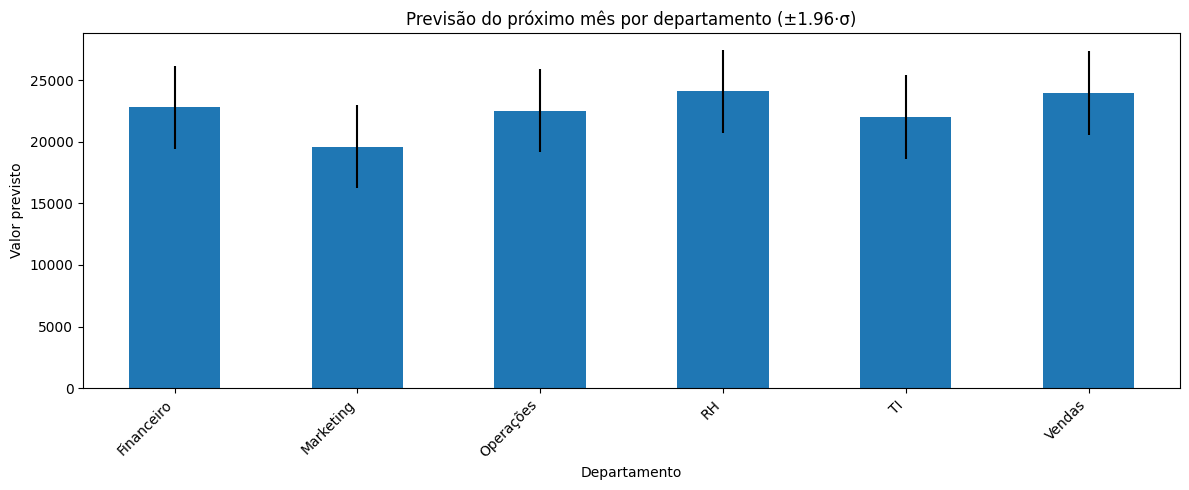

Figura salva em: c:\Users\cesar.carvalho\OneDrive - Grupo Primo\Área de Trabalho\Teste\data\processed\prediction_bars_next_month.png


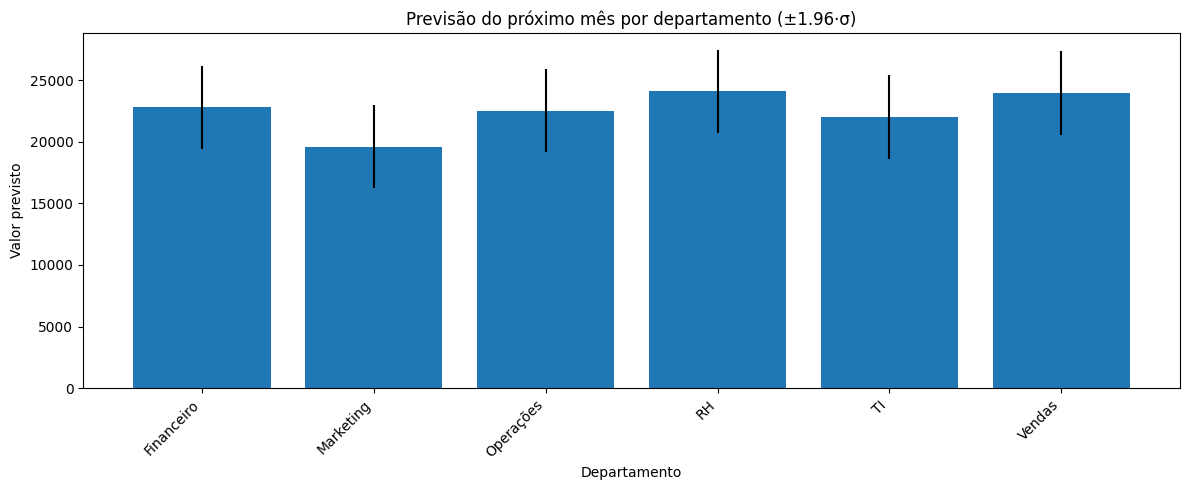

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rf_test_pred = models.get("random_forest")
if rf_test_pred is None:
    rf_test_pred = rf.predict(X_test)

residuals = (y_test.values - np.array(rf_test_pred, dtype=float))
sigma = float(np.std(residuals, ddof=1)) if residuals.size > 1 else 0.0

fig = plt.figure(figsize=(10, 4))

plt.scatter(y_test, rf_test_pred, alpha=0.8)
lims = [min(np.min(y_test), np.min(rf_test_pred)), max(np.max(y_test), np.max(rf_test_pred))]
plt.plot(lims, lims, linestyle="--")
plt.title("Verdade vs Predito (mês de teste) — Random Forest")
plt.xlabel("Verdade (y)")
plt.ylabel("Predito")
plt.tight_layout()
plt.show()

preds = latest.copy()
preds["pred"] = preds["pred_rf"]
preds["err"] = 1.96 * sigma
preds["lo"] = preds["pred"] - preds["err"]
preds["hi"] = preds["pred"] + preds["err"]

ax = preds.plot(
    x="nome_departamento",
    y="pred",
    kind="bar",
    yerr=preds["err"].values,
    figsize=(12, 5),
    legend=False
)
ax.set_title("Previsão do próximo mês por departamento (±1.96·σ)")
ax.set_xlabel("Departamento")
ax.set_ylabel("Valor previsto")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

fig_path = DATA_DIR / "prediction_bars_next_month.png"
plt.figure(figsize=(12, 5))
plt.bar(preds["nome_departamento"], preds["pred"], yerr=preds["err"].values)
plt.xticks(rotation=45, ha="right")
plt.title("Previsão do próximo mês por departamento (±1.96·σ)")
plt.xlabel("Departamento")
plt.ylabel("Valor previsto")
plt.tight_layout()
plt.savefig(fig_path, dpi=120)
print("Figura salva em:", fig_path)


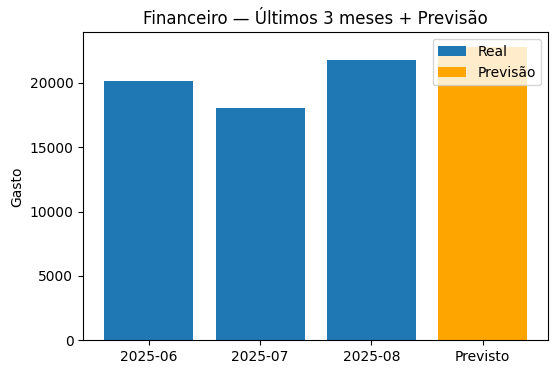

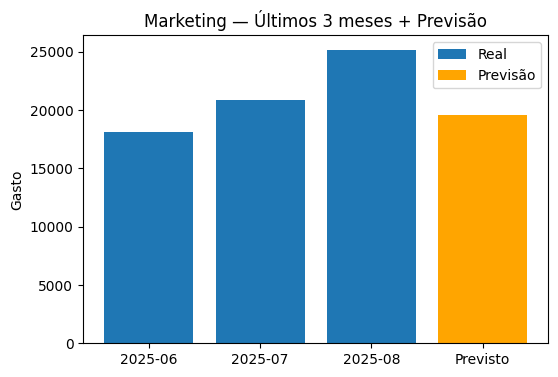

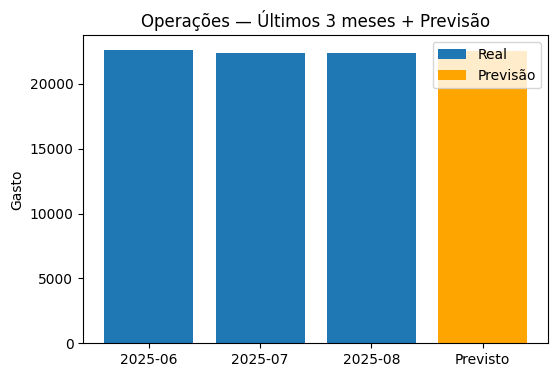

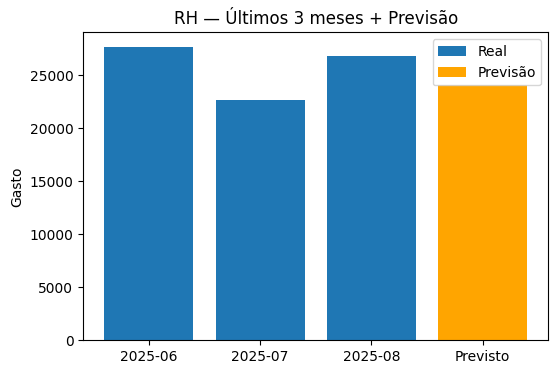

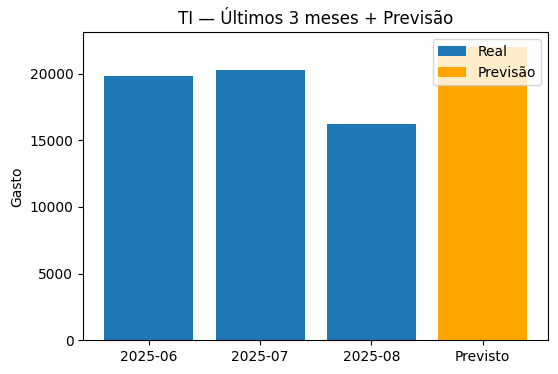

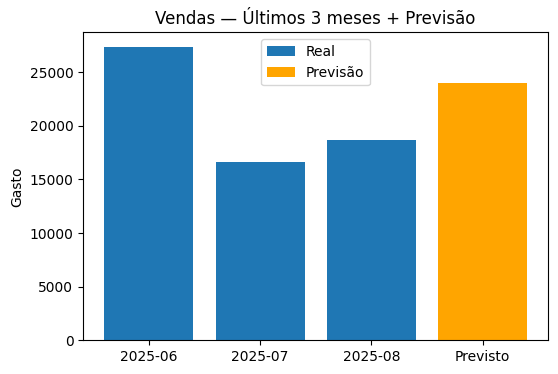

In [ ]:
import matplotlib.pyplot as plt

plots = []
for dept in latest["nome_departamento"].unique():
    hist = feats.loc[feats["nome_departamento"] == dept].sort_values("mes").tail(3)
    pred_val = latest.loc[latest["nome_departamento"] == dept, "pred_rf"].values[0]

    plt.figure(figsize=(6,4))
    plt.bar(hist["mes"].dt.strftime("%Y-%m"), hist["gasto_total"], label="Real")
    plt.bar("Previsto", pred_val, color="orange", label="Previsão")
    plt.title(f"{dept} — Últimos 3 meses + Previsão")
    plt.ylabel("Gasto")
    plt.legend()
    plt.show()
